# ECEN-758 Fall 2023: Group Project

#### Group 34
- Yu-Sheng Chen
- Emily Chang
- Jen Li Kao


References
- https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
- https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html
- https://lightgbm.readthedocs.io/en/stable/Parameters.html
- https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm


## Part 1: Data importing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Load the FashionMNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Data Cleansing and Transformation
# Flatten the images and normalize pixel values to the range [0, 1]
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# Data Splitting
# Split the data into training, validation
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


## Part 2: EDA

Training Set:
[0]T-shirt/top: 4231 samples
[1]Trouser: 4165 samples
[2]Pullover: 4199 samples
[3]Dress: 4211 samples
[4]Coat: 4185 samples
[5]Sandal: 4217 samples
[6]Shirt: 4189 samples
[7]Sneaker: 4241 samples
[8]Bag: 4175 samples
[9]Ankle boot: 4187 samples

Validation Set:
[0]T-shirt/top: 1769 samples
[1]Trouser: 1835 samples
[2]Pullover: 1801 samples
[3]Dress: 1789 samples
[4]Coat: 1815 samples
[5]Sandal: 1783 samples
[6]Shirt: 1811 samples
[7]Sneaker: 1759 samples
[8]Bag: 1825 samples
[9]Ankle boot: 1813 samples

Testing Set:
[0]T-shirt/top: 1000 samples
[1]Trouser: 1000 samples
[2]Pullover: 1000 samples
[3]Dress: 1000 samples
[4]Coat: 1000 samples
[5]Sandal: 1000 samples
[6]Shirt: 1000 samples
[7]Sneaker: 1000 samples
[8]Bag: 1000 samples
[9]Ankle boot: 1000 samples

Example images:


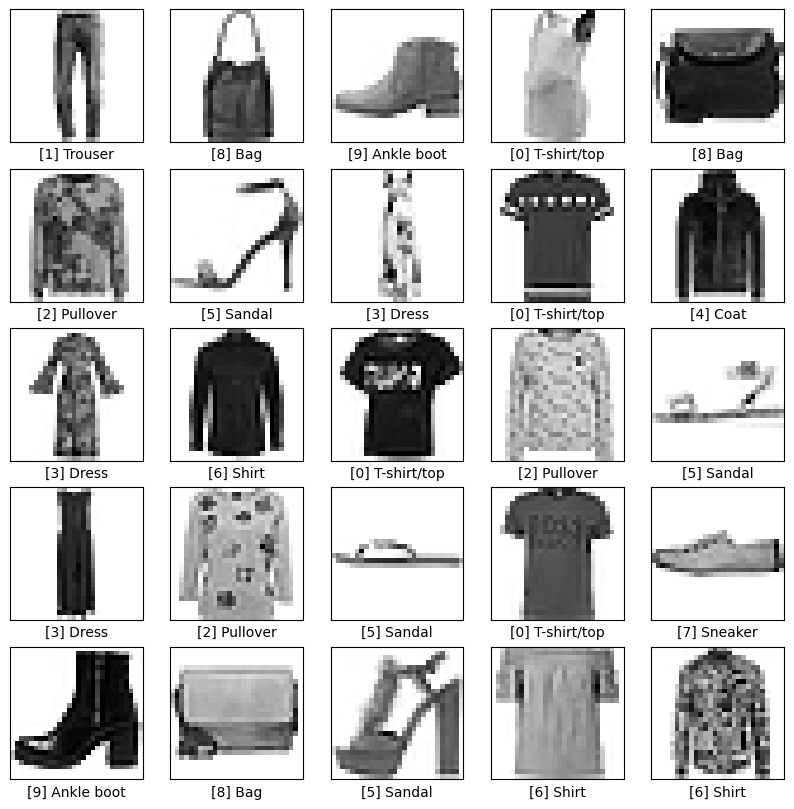

In [ ]:
# Exploratory Data Analysis
# Descriptive Statistics
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Calculate class distribution (Training Set)
class_distribution = np.bincount(y_train)
print("Training Set:")
for i, count in enumerate(class_distribution):
    print(f"{[i]}{class_labels[i]}: {count} samples")

# Calculate class distribution (Validation Set)
class_distribution = np.bincount(y_val)
print("\nValidation Set:")
for i, count in enumerate(class_distribution):
    print(f"{[i]}{class_labels[i]}: {count} samples")

# Calculate class distribution (Testing Set)
class_distribution = np.bincount(test_labels)
print("\nTesting Set:")
for i, count in enumerate(class_distribution):
    print(f"{[i]}{class_labels[i]}: {count} samples")

# Data Visualization
# Plot example images from different classes
print("\nExample images:")
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    label = f"{[y_train[i]]} {class_labels[y_train[i]]}"
    plt.xlabel(label)
    #plt.xlabel({i} class_labels[y_train[i]])
plt.show()

In [ ]:
from sklearn.manifold import TSNE
X_flat = train_images.reshape(train_images.shape[0], -1)  # Flatten images
y_test_labels = [class_labels[label] for label in train_labels]  # Convert numerical labels to class labels
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flat)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test_labels, palette=sns.color_palette("tab10"))
plt.title('t-SNE Visualization - Training Set')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
X_flat = test_images.reshape(test_images.shape[0], -1)  # Flatten images
y_test_labels = [class_labels[label] for label in test_labels]  # Convert numerical labels to class labels
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flat)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test_labels, palette=sns.color_palette("tab10"))
plt.title('t-SNE Visualization - Testing Set')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Part 3: Deep CNN

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import SubsetRandomSampler

### 3-1 Load and Visualize Dataset

In [ ]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(X_train).permute(0, 3, 1, 2) # Change X_train shape[32, 28, 28, 1] into [32, 1, 28, 28] to fit the conv2D layer
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(X_val).permute(0, 3, 1, 2) # Change X_train shape[32, 28, 28, 1] into [32, 1, 28, 28] to fit the conv2D layer
targetsTest = torch.from_numpy(y_val).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train_data = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test_data = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

In [ ]:
# checking our data pixel value
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(images, images.shape, len(images), images[0].shape)
print()
print(labels, labels.shape, len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    self.fc1 = nn.Linear(32*7*7,512)
    self.fc2 = nn.Linear(512,256)
    self.out = nn.Linear(256,10)
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # flatten image input
    x = x.view(-1, 32*7*7)
    x = self.dropout(x)
    # add hidden layer, with relu activation function
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.out(x)
    return x

In [ ]:
model = Classifier()
#Weight normalization
def weight_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model.apply(weight_init_normal)
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()


print(model,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


In [ ]:
#EarlyStop Function
class EarlyStopping:
    def __init__(self, mode, path, patience=5, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")

        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0

    def _is_improvement(self, val_score):
        """Return True iff val_score is better than self.best_score."""
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False

    def __call__(self, val_score, model):
        """Return True iff self.counter >= self.patience.
        """

        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Val loss improved.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

In [ ]:
# Specify Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
es = EarlyStopping(mode='min', path='model.pth', patience=5) #Set the Early-Stopping callback for overfitting detection

# Number of epochs to train for
loss_keeper = {'train':[], 'valid':[]}
epochs = 50
# minimum validation loss ----- set initial minimum to infinity
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    #####################
    # TRAINING PHASE #
    #####################
    model.train() # TURN ON DROPOUT for training
    for images, labels in train_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    #######################
    # VALIDATION PHASE #
    #######################
    model.eval() # TURN OFF DROPOUT for validation
    for images, labels in valid_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels = images.cuda(),labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        valid_loss += loss.item()

    # Calculating loss over entire batch size for every epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # saving loss values
    loss_keeper['train'].append(train_loss)
    loss_keeper['valid'].append(valid_loss)

    print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")

    # early stopping
    if es(valid_loss, model):#If detecting the valid loss increase more than 5 times than stopping the training loop early
        break

    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
        z = type(model).__name__
        torch.save(model.state_dict(), z+'_model.pth')
        valid_loss_min = valid_loss


Epoch : 1	Training Loss : 0.5138534004860313	Validation Loss : 0.3198437521011432
Val loss improved.
Validation loss decreased from : inf ----> 0.3198437521011432 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3313926996610724	Validation Loss : 0.25748338068282883
Val loss improved.
Validation loss decreased from : 0.3198437521011432 ----> 0.25748338068282883 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2851867405080605	Validation Loss : 0.22954894423694758
Val loss improved.
Validation loss decreased from : 0.25748338068282883 ----> 0.22954894423694758 ----> Saving Model.......

Epoch : 4	Training Loss : 0.2533944769842608	Validation Loss : 0.1984901134965988
Val loss improved.
Validation loss decreased from : 0.22954894423694758 ----> 0.1984901134965988 ----> Saving Model.......

Epoch : 5	Training Loss : 0.23469381402931136	Validation Loss : 0.16831103527758154
Val loss improved.
Validation loss decreased from : 0.1984901134965988 ----> 0.16831103527758154 ----> S

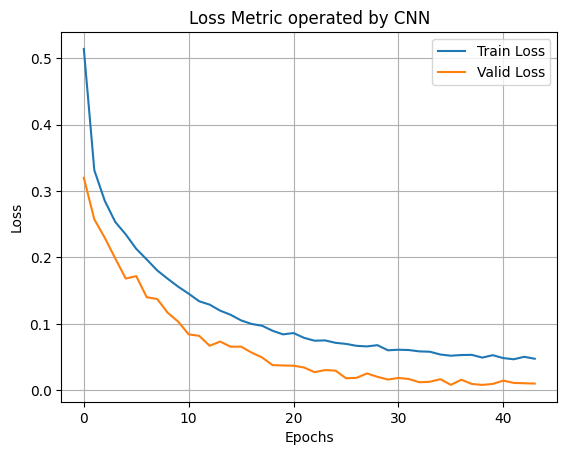

In [ ]:
plt.plot(loss_keeper['train'], label='Train Loss')
plt.plot(loss_keeper['valid'], label='Valid Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Metric operated by CNN")
plt.grid()
plt.legend()

In [ ]:
print(model.state_dict)

<bound method Module.state_dict of Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


In [ ]:
correct = 0
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # test the model with dropout layers off
for images,labels in test_loader:
    if use_cuda and torch.cuda.is_available():
        images, labels = images.cuda(),labels.cuda()
    output = model(images)
    loss = criterion(output,labels)
    test_loss += loss.item()
    _,pred = torch.max(output,1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader)
print(f'For {type(model).__name__} :')
print(f"Test Loss: {test_loss}")
print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
for i in range(10):
  if class_total[i] > 0:
      print(f"Test Accuracy of class {class_labels[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
  else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")


For Classifier :
Test Loss: 0.33402818323952127
Correctly predicted per class : [1538.0, 1807.0, 1609.0, 1661.0, 1629.0, 1754.0, 1363.0, 1682.0, 1794.0, 1768.0], Total correctly perdicted : 16605.0
Total Predictions per class : [1769.0, 1835.0, 1801.0, 1789.0, 1815.0, 1783.0, 1811.0, 1759.0, 1825.0, 1813.0], Total predictions to be made : 18000.0

Test Accuracy of class T-shirt/top : 86.94177501413228% where 1538 of 1769 were predicted correctly
Test Accuracy of class Trouser : 98.47411444141689% where 1807 of 1835 were predicted correctly
Test Accuracy of class Pullover : 89.33925596890616% where 1609 of 1801 were predicted correctly
Test Accuracy of class Dress : 92.84516489659028% where 1661 of 1789 were predicted correctly
Test Accuracy of class Coat : 89.75206611570248% where 1629 of 1815 were predicted correctly
Test Accuracy of class Sandal : 98.37352776219855% where 1754 of 1783 were predicted correctly
Test Accuracy of class Shirt : 75.26228602981779% where 1363 of 1811 were p

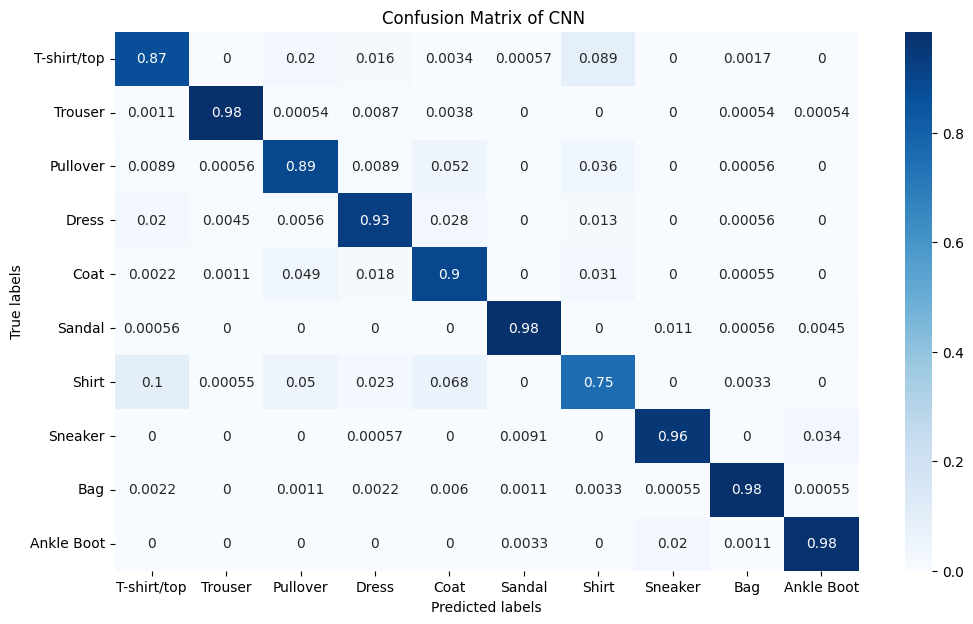

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
          images, labels = images.cuda(),labels.cuda()
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis = 1)[:, None], index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of CNN ')
plt.savefig('output.png')

In [ ]:
import sklearn.metrics as metrics
# print the report
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(y_true, y_pred)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1769
           1       0.99      0.98      0.99      1835
           2       0.88      0.89      0.88      1801
           3       0.92      0.93      0.93      1789
           4       0.85      0.90      0.87      1815
           5       0.99      0.98      0.98      1783
           6       0.82      0.75      0.78      1811
           7       0.97      0.96      0.96      1759
           8       0.99      0.98      0.99      1825
           9       0.96      0.98      0.97      1813

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000




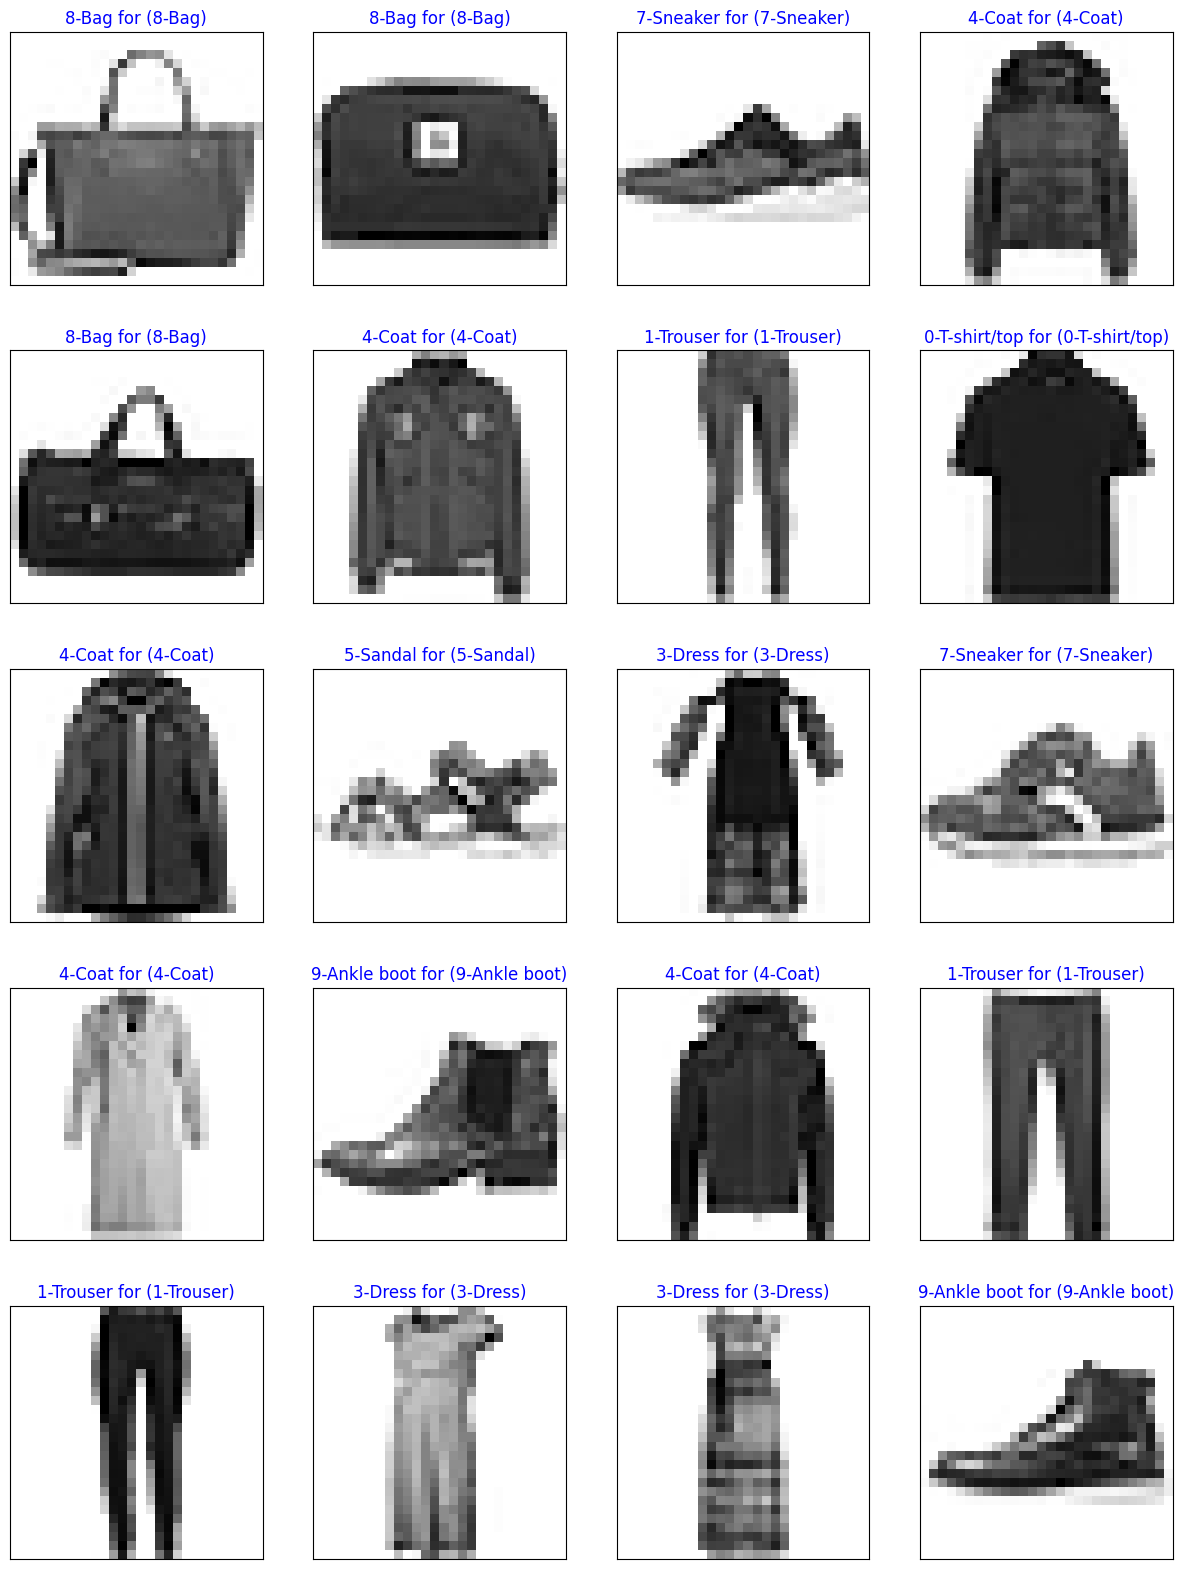

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
if use_cuda and torch.cuda.is_available():
  images, labels = images.cuda(), labels.cuda()
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

fig = plt.figure(figsize=(15, 20))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(images[idx]), cmap = plt.cm.binary)
    ax.set_title("{}-{} for ({}-{})".format(str(preds[idx].item()), class_labels[preds[idx].item()],str(labels[idx].item()),class_labels[labels[idx].item()]),
                color = ("blue" if preds[idx]==labels[idx] else "red"))

## Part 4: LightGBM

### 4-1 Data Reshaping and Model Training

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
# Using X_train, X_valid, y_train, y_valid from Part 1
# Convert training and validation sets into LightGBM dataset formats
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
dtrain = lgb.Dataset(X_train_flat, label=y_train)
dvalid = lgb.Dataset(X_val_flat, label=y_val)

# Set up the parameters
params = {
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'objective': 'multiclass',  # Multiclass target feature
    'num_class': 10,  # Number of classes
    'num_leaves': 31,  # Number of leaves in full tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Part of features to be used for each iteration
    'bagging_fraction': 0.8,  # Part of data to be used for each iteration
    'bagging_freq': 5,  # Frequency for bagging
    'verbose': 1  # Verbose output for tracking progress
}

# Train the model with early stopping
evals_result = {}
lgbm = lgb.train(params,
          dtrain,
          valid_sets=[dtrain, dvalid],
          valid_names=['train', 'valid'],
          num_boost_round=1000,
          callbacks=[lgb.early_stopping(stopping_rounds=5),
                lgb.record_evaluation(eval_result=evals_result)])

# save the model
lgbm.save_model("./lgbmodel.txt")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.730106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168842
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 783
[LightGBM] [Info] Start training from score -2.295231
[LightGBM] [Info] Start training from score -2.310953
[LightGBM] [Info] Start training from score -2.302823
[LightGBM] [Info] Start training from score -2.299969
[LightGBM] [Info] Start training from score -2.306163
[LightGBM] [Info] Start training from score -2.298546
[LightGBM] [Info] Start training from score -2.305208
[LightGBM] [Info] Start training from score -2.292871
[LightGBM] [Info] Start training from score -2.308555
[LightGBM] [Info] Start training from score -2.305685
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	train's multi_logloss: 0.0453287	valid's multi_logloss: 0.273035


### 4-2 Evaluating Training/Validation Performance

Validation Accuracy: 0.9016111111111111


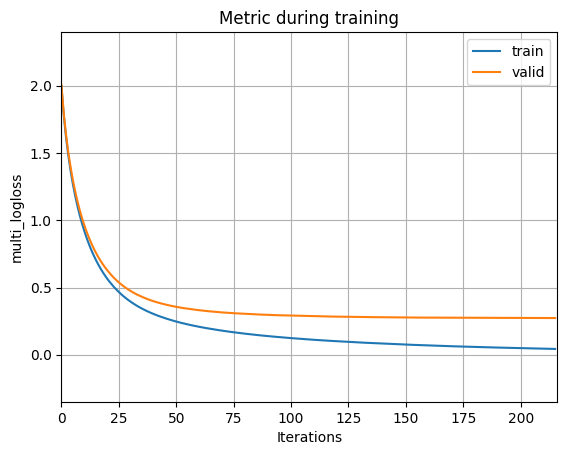

In [ ]:
# load the model
lgbm = lgb.Booster(model_file='./lgbmodel.txt')

# Prediction on the validation set
y_pred = lgbm.predict(X_val_flat, num_iteration=lgbm.best_iteration)
# Convert probabilities into predicted class
y_pred_max = [np.argmax(line) for line in y_pred]

accuracy = accuracy_score(y_val, y_pred_max)
print(f"Validation Accuracy: {accuracy}")

# Plot the evaluation for training-validation
lgb.plot_metric(evals_result, metric='multi_logloss')
plt.show()

### 4-3 Evaluation on Testing Dataset

Accuracy: 0.8926
Classification Report for LightGBM:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       1.00      0.96      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.90      0.90      0.90      1000
           4       0.81      0.83      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.73      0.66      0.69      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



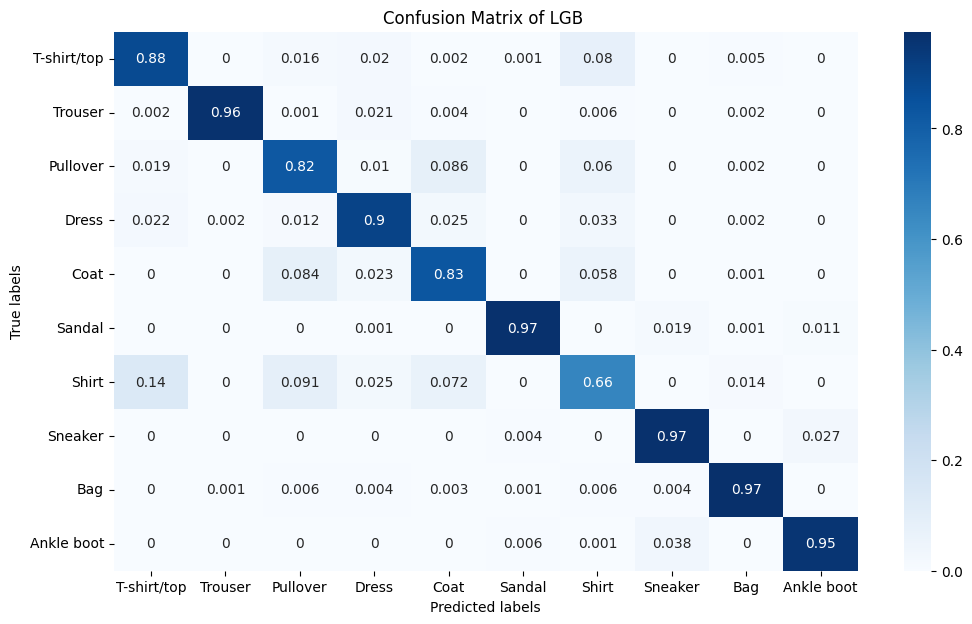

In [ ]:
# Predictions on Testing Dataset
X_test_flat = test_images.reshape(test_images.shape[0], -1)
y_pred = np.argmax(lgbm.predict(X_test_flat), axis=1)
y_test = test_labels

# Evaluate the model on Testing Dataset
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for LightGBM:\n", classification_report(y_test, y_pred))


# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis = 1)[:, None], index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of LGB ')
plt.savefig('confusionMat_lgb.png')

### 4-4 Find Feature Importance

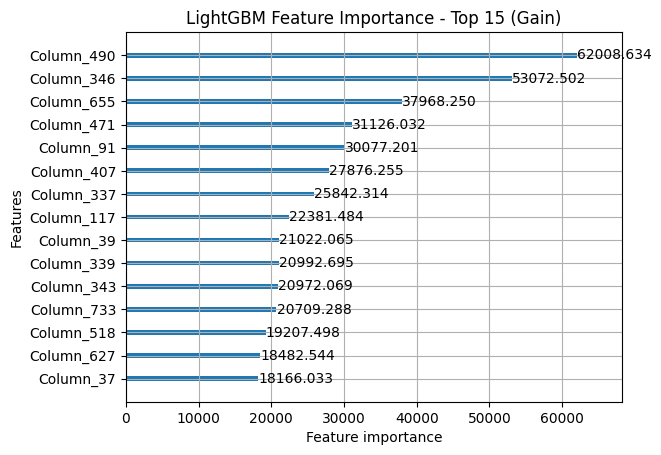

In [ ]:
lgb.plot_importance(lgbm, importance_type="gain",
          max_num_features=15, title="LightGBM Feature Importance - Top 15 (Gain)");

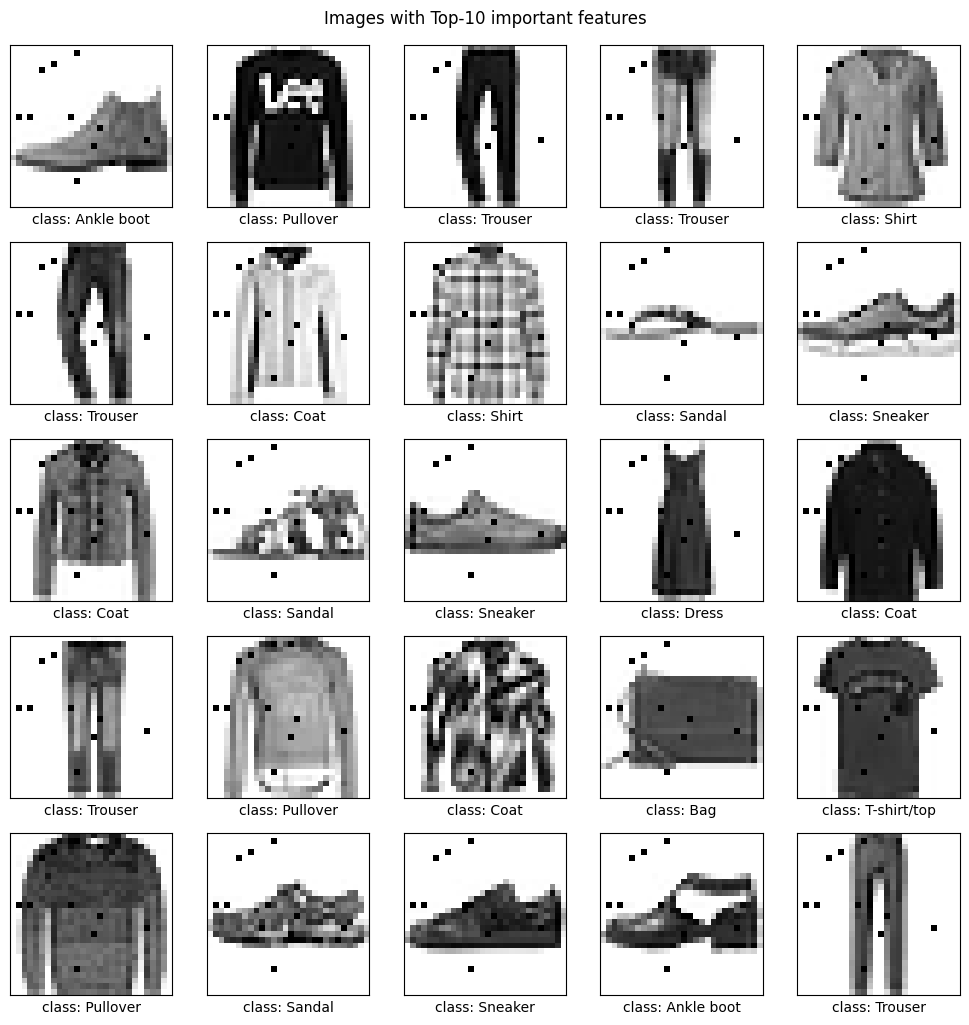

In [ ]:
# Config for plotting important Features
# Note that the top_features_gain are hard-coded and from the above Feature Importance chart.
top_features = [770, 14, 10, 126, 13, 70, 301, 269, 17, 300]
top_features_gain = [490, 346, 655, 471, 91, 407, 337, 117, 39, 339]
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_images = 25
top_images = test_images[:num_images]


# Function to overlay important pixels
def overlay_important_pixels(image, important_pixels, image_shape=(28, 28)):
    reshaped_image = image.reshape(image_shape)
    overlay = np.zeros(image_shape)

    for pixel in important_pixels:
        x, y = divmod(pixel, image_shape[0])
        overlay[x, y] = 1  # Mark the important pixel

    return np.maximum(reshaped_image, overlay)



# Plotting the images with highlighted important pixels
plt.figure(figsize=(10, 10))
for i, image in zip(range(25), top_images):# enumerate(top_images)

    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Overlay the important pixels
    highlighted_image = overlay_important_pixels(image, top_features_gain)

    plt.imshow(highlighted_image, cmap=plt.cm.binary)
    plt.xlabel(f'class: {class_labels[y_test[i]]}')

plt.tight_layout()
plt.suptitle("Images with Top-10 important features", y=1.02)
plt.show()